In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

## Soccer Player and Ball Tracking using Faster R-CNN and Deep SORT

### 1. Introduction
This notebook implements a soccer player and ball tracking system using:
- Faster R-CNN for object detection
- Deep SORT for object tracking
The system can detect and track multiple players and the ball simultaneously across video frames.

### 2. Setup and Dependencies
First, we import necessary libraries and set up GPU support for faster processing.

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

### Downloading the Youtube Video


In [11]:
from pytube import YouTube
import yt_dlp

def download_tutorial_video(url, save_path):
    ydl_opts = {
        'outtmpl': f'{save_path}/%(title)s.%(ext)s',
        'format': 'best'
    }
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        print("Download completed")
    except Exception as e:
        print(f"Error downloading video: {e}")

In [12]:
download_tutorial_video("https://youtu.be/l3NJNFmg09k", "./content/")

[youtube] Extracting URL: https://youtu.be/l3NJNFmg09k
[youtube] l3NJNFmg09k: Downloading webpage
[youtube] l3NJNFmg09k: Downloading ios player API JSON
[youtube] l3NJNFmg09k: Downloading mweb player API JSON
[youtube] l3NJNFmg09k: Downloading player 0ccfa671
[youtube] l3NJNFmg09k: Downloading m3u8 information
[info] l3NJNFmg09k: Downloading 1 format(s): 18
[download] content\Football match.mp4 has already been downloaded
[download] 100% of    3.57MiB
Download completed


In [13]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    # Get the name of the current GPU
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"Using GPU: {gpu_name}")
else:
    print("CUDA is not available. Using CPU.")

CUDA Available: True
Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 3. Faster R-CNN Implementation

### 3.1 Architecture Overview
Faster R-CNN consists of three main components:

1. **Backbone Network (ResNet50)**

   The backbone network processes each frame through multiple stages:
   
   a. **Initial Convolution Layer**
   - 7×7 convolution, stride=2
   - Captures basic visual features
   
   b. **ResNet Blocks**
   - Multiple residual blocks
   - Progressively extract higher-level features
   - Output feature maps at different scales

2. **Region Proposal Network (RPN)**

   RPN generates potential object locations through:
   
   a. **Anchor Generation**
   - Multiple scales and aspect ratios
   - Dense coverage of input image
   
   b. **Classification Branch**
   - Predicts "objectness" score
   - Binary classification (foreground/background)
   
   c. **Box Regression Branch**
   - Refines anchor box coordinates
   - Outputs proposal coordinates

   2.1 **ROI Pooling**
   
   Converts variable-sized proposals to fixed size:
   1. Divides proposals into fixed grid
   2. Max-pools each cell
   3. Outputs fixed-size feature maps (7×7)

3. **Detection Head**

   Final classification and localization:
   
   a. **Classification Branch**
   - Multi-class classification
   - Identifies players and ball
   
   b. **Box Regression**
   - Final bounding box refinement
   - Precise object localization


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

c:\Users\solom\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\solom\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Classes of the Objects that we are classifying

In [15]:
CLASSES = ['__background__', 'person', 'sports ball']
CLASS_IDS = {1: 'person', 37: 'sports ball'}

### Function to process a single frame through Faster R-CNN

In [16]:
def process_frame(frame):
   
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Transform frame to tensor
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(rgb_frame)
    
    # Get predictions
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
        
    return prediction[0], rgb_frame

### Function to draw detection boxes on frame

In [17]:
def draw_detections(frame, prediction, threshold=0.5):
    """
    Draw detection boxes on frame
    """
    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']
    
    # Draw boxes for high confidence predictions
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold and label.item() in CLASS_IDS:
            box = box.cpu().numpy()
            # Green for players, red for ball
            color = (0, 255, 0) if CLASS_IDS[label.item()] == 'person' else (0, 0, 255)
            
            # Draw rectangle
            cv2.rectangle(frame,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            
            # Add label and score
            label_text = f"{CLASS_IDS[label.item()]}: {score:.2f}"
            cv2.putText(frame, label_text,
                       (int(box[0]), int(box[1]-10)),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return frame

### Function to Visualize intermediate feature maps from backbone network


In [18]:
def visualize_feature_maps(frame):
    """
    Visualize intermediate feature maps from backbone network
    """
    # Convert frame to tensor
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(frame).unsqueeze(0).to(device)
    
    # Get feature maps from backbone
    features = model.backbone(image_tensor)
    
    # Plot feature maps
    plt.figure(figsize=(15, 5))
    for idx, (name, feat) in enumerate(features.items()):
        plt.subplot(1, len(features), idx+1)
        plt.imshow(feat[0, 0].cpu().detach().numpy())
        plt.title(f'Feature Map {name}')
        plt.axis('off')
    plt.show()

In [19]:
def visualize_rpn_proposals(frame, prediction):
    """Visualize Region Proposal Network outputs"""
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Draw proposals before NMS
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    for box, score in zip(boxes, scores):
        if score > 0.5:  # Confidence threshold
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, color='red')
            plt.gca().add_patch(rect)
    
    plt.title('RPN Proposals')
    plt.axis('off')
    plt.show()

In [21]:
def visualize_final_detections(frame, prediction):
    processed_frame = draw_detections(frame.copy(), prediction)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
    plt.title('Final Detections')
    plt.axis('off')
    plt.show()

### Function to process entire video and save output

In [22]:
def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        print(f"Processing frame {frame_count}/{total_frames}")
        
        # Get predictions and draw boxes
        prediction, rgb_frame = process_frame(frame)
        processed_frame = draw_detections(frame, prediction)
        
        # Write frame
        out.write(processed_frame)
        
        # Display frame (optional)
        cv2.imshow('Soccer Analysis', processed_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

Processing frame 1/1074
Processing frame 2/1074
Processing frame 3/1074
Processing frame 4/1074
Processing frame 5/1074
Processing frame 6/1074
Processing frame 7/1074
Processing frame 8/1074
Processing frame 9/1074
Processing frame 10/1074
Processing frame 11/1074
Processing frame 12/1074
Processing frame 13/1074
Processing frame 14/1074
Processing frame 15/1074
Processing frame 16/1074
Processing frame 17/1074
Processing frame 18/1074
Processing frame 19/1074
Processing frame 20/1074
Processing frame 21/1074
Processing frame 22/1074
Processing frame 23/1074
Processing frame 24/1074
Processing frame 25/1074
Processing frame 26/1074
Processing frame 27/1074
Processing frame 28/1074
Processing frame 29/1074
Processing frame 30/1074
Processing frame 31/1074
Processing frame 32/1074
Processing frame 33/1074
Processing frame 34/1074
Processing frame 35/1074
Processing frame 36/1074
Processing frame 37/1074
Processing frame 38/1074
Processing frame 39/1074
Processing frame 40/1074
Processin

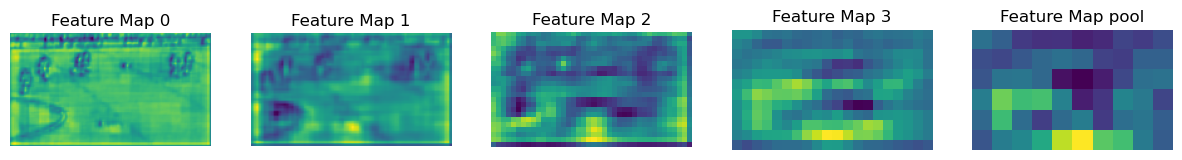

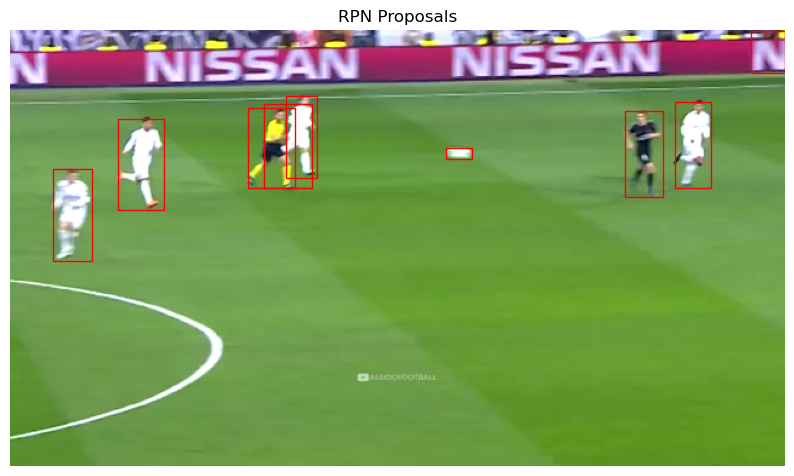

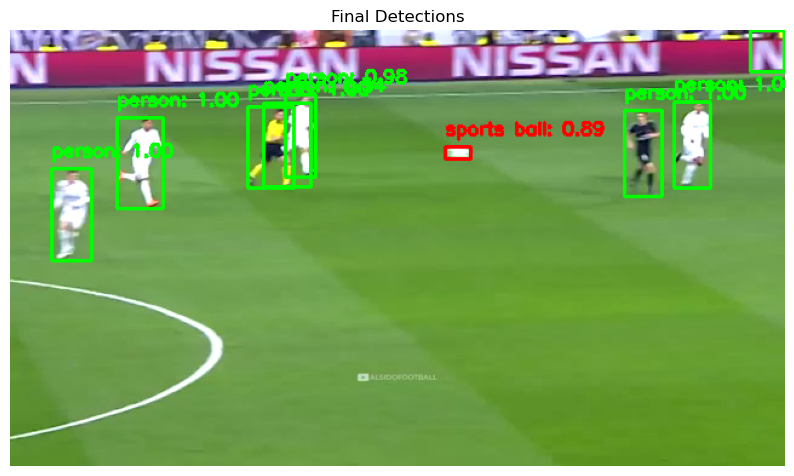

In [24]:

input_video = "./content/Football match.mp4"  
output_video = "./content/output_soccer.mp4"


process_video(input_video, output_video)


# Process a single frame for visualization
cap = cv2.VideoCapture(input_video)
ret, frame = cap.read()
cap.release()

if ret:
    # Get predictions
    prediction, rgb_frame = process_frame(frame)
    
    # 1. Visualize backbone feature maps
    visualize_feature_maps(rgb_frame)
    
    # 2. Visualize RPN proposals
    visualize_rpn_proposals(frame, prediction)
    
    # 3. Visualize final detections
    visualize_final_detections(frame, prediction)

Complete Video: https://drive.google.com/file/d/1G7G6CjaRlJTjMB5dr2DNOqCTO9p0Yd1N/view?usp=drive_link

## 4. Deep SORT Integration

### 4.1 Deep SORT Architecture
Deep SORT extends detection by adding:
1. **Feature Extraction**
   - Creates unique appearance descriptors for each object
   - Helps maintain identity through occlusions

2. **Kalman Filter**
   - State vector: [x, y, a, h, vx, vy, va, vh]
   - Predicts object motion
   - Handles missing detections

3. **Data Association**
   - Combines appearance and motion information
   - Uses Hungarian algorithm for optimal matching
   - Maintains consistent object IDs

The final output shows:
- Green boxes: Player detections with tracking IDs
- Red boxes: Ball detection with tracking ID
- Consistent tracking through occlusions

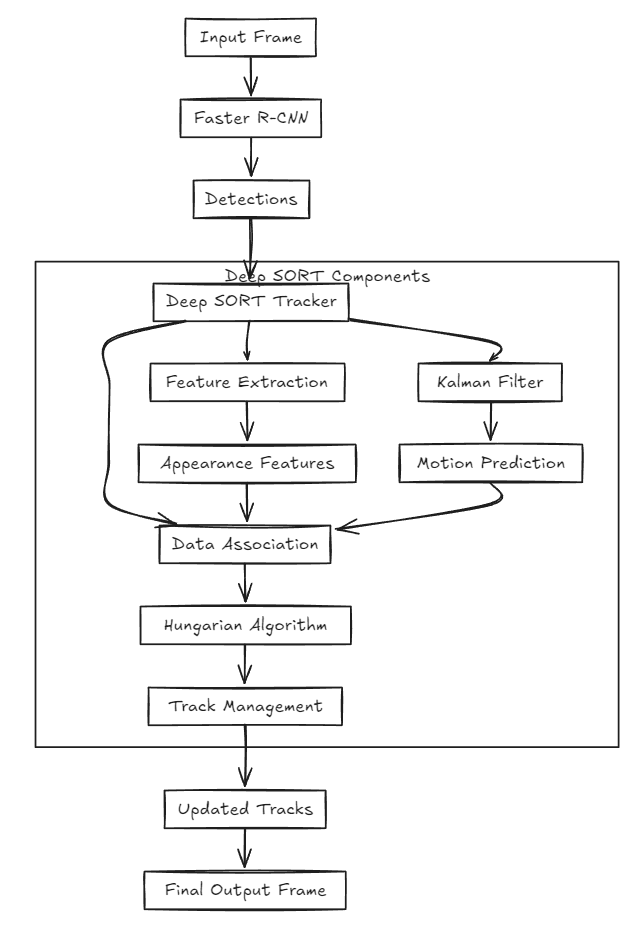

In [ ]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Initialize Deep SORT tracker
tracker = DeepSort(
    max_age=5,
    n_init=2,
    max_cosine_distance=0.2,
    nn_budget=100,
    embedder="mobilenet",
    embedder_gpu=True,
    half=True,
    bgr=True
)

def process_video_with_tracking(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        print(f"Processing frame {frame_count}/{total_frames}")
        
        # Get Faster R-CNN detections
        prediction, rgb_frame = process_frame(frame)
        
        # Convert detections to Deep SORT format
        detections = []
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        
        # Filter and format detections
        for box, score, label in zip(boxes, scores, labels):
            if score > 0.7 and label.item() in CLASS_IDS:  # Higher confidence threshold
                x1, y1, x2, y2 = box.astype(int)  # Convert to int
                w = x2 - x1
                h = y2 - y1
                
                # Deep SORT expects detections in format: [[x1,y1,w,h], confidence, class_id]
                detection = [[x1, y1, w, h], score, label.item()]
                detections.append(detection)
        
        # Update tracker
        tracks = tracker.update_tracks(detections, frame=frame)
        
        # Draw tracks
        for track in tracks:
            if not track.is_confirmed():
                continue
                
            track_id = track.track_id
            ltrb = track.to_ltrb()  # Returns (left, top, right, bottom)
            
            # Draw bounding box
            color = (0, 255, 0) if track.get_det_class() == 1 else (0, 0, 255)
            cv2.rectangle(frame, 
                         (int(ltrb[0]), int(ltrb[1])), 
                         (int(ltrb[2]), int(ltrb[3])), 
                         color, 2)
            
            # Draw ID and class
            label_text = f"{CLASS_IDS[track.get_det_class()]}-{track_id}"
            cv2.putText(frame, 
                       label_text,
                       (int(ltrb[0]), int(ltrb[1]-10)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       0.5, color, 2)
        
        out.write(frame)
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Process video with tracking
input_video = "./content/Football match.mp4"
output_video = "./output_with_tracking.mp4"
process_video_with_tracking(input_video, output_video)

c:\Users\solom\anaconda3\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch

Processing frame 1/1074
Processing frame 2/1074
Processing frame 3/1074
Processing frame 4/1074
Processing frame 5/1074
Processing frame 6/1074
Processing frame 7/1074
Processing frame 8/1074
Processing frame 9/1074
Processing frame 10/1074
Processing frame 11/1074
Processing frame 12/1074
Processing frame 13/1074
Processing frame 14/1074
Processing frame 15/1074
Processing frame 16/1074
Processing frame 17/1074
Processing frame 18/1074
Processing frame 19/1074
Processing frame 20/1074
Processing frame 21/1074
Processing frame 22/1074
Processing frame 23/1074
Processing frame 24/1074
Processing frame 25/1074
Processing frame 26/1074
Processing frame 27/1074
Processing frame 28/1074
Processing frame 29/1074
Processing frame 30/1074
Processing frame 31/1074
Processing frame 32/1074
Processing frame 33/1074
Processing frame 34/1074
Processing frame 35/1074
Processing frame 36/1074
Processing frame 37/1074
Processing frame 38/1074
Processing frame 39/1074
Processing frame 40/1074
Processin

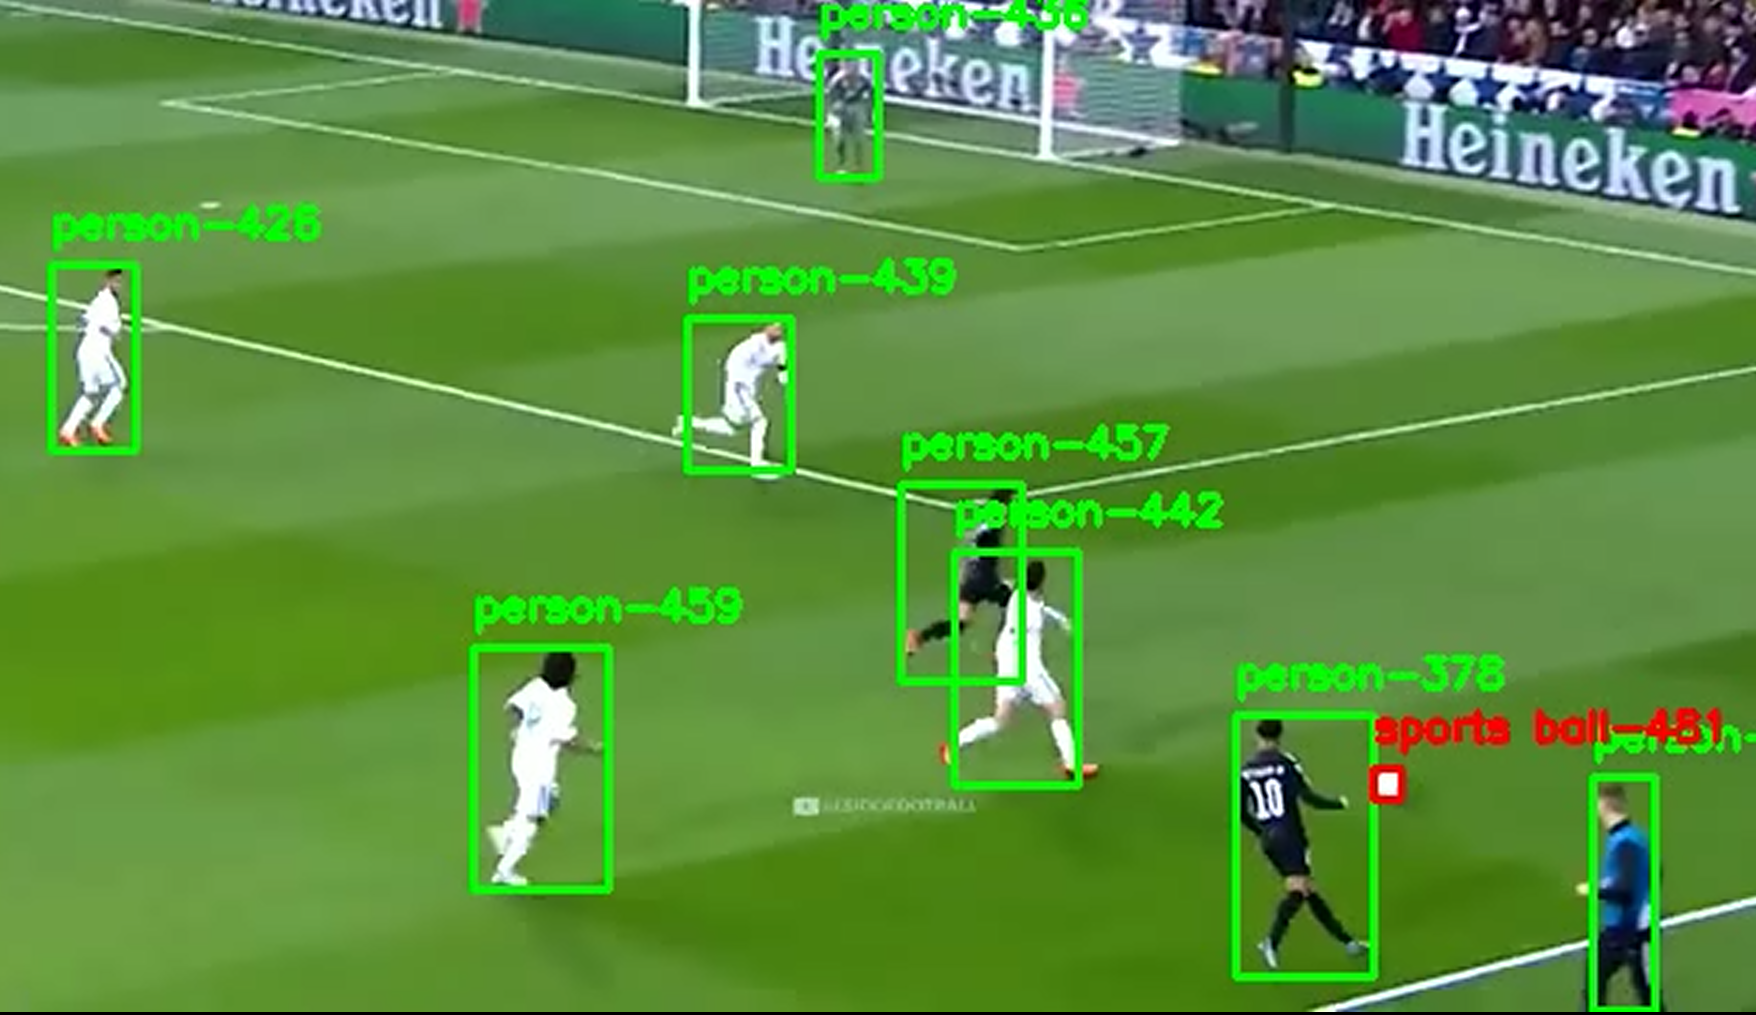

Complete video: https://drive.google.com/file/d/1bPW-gnXTSFBFGwquAFOmjnz_IJvXdCw5/view?usp=sharing

## 5. Results and Analysis
- Successfully detects and tracks multiple players
- Maintains consistent player IDs
- Handles occlusions and crossing paths
- Tracks fast-moving ball across frames

## 6. Mathematical Foundation

### 6.1 Kalman Filter Equations
The Kalman filter uses these key equations:
1. Prediction:

   x̂ₖ|ₖ₋₁ = Fₖx̂ₖ₋₁|ₖ₋₁
   
   Pₖ|ₖ₋₁ = FₖPₖ₋₁|ₖ₋₁Fₖᵀ + Qₖ

2. Update:

   Kₖ = Pₖ|ₖ₋₁Hₖᵀ(HₖPₖ|ₖ₋₁Hₖᵀ + Rₖ)⁻¹

   x̂ₖ|ₖ = x̂ₖ|ₖ₋₁ + Kₖ(zₖ - Hₖx̂ₖ|ₖ₋₁)
   
   Pₖ|ₖ = (I - KₖHₖ)Pₖ|ₖ₋₁

### 6.2 Hungarian Algorithm
Used for optimal assignment between tracks and detections:
- Creates cost matrix of track-detection pairs
- Finds minimum cost assignment
- Ensures one-to-one matching